# Notebook 6 - Using Total Sky Imager data to pick GOES cloud thresholds

From the Friday Harbor Labs Camera data, we found thresholds using visible reflectivity (green) and infrared (red). This performed well over the San Juan Islands but struggled significantly in mountainous areas with snow and glaciers. Using the decision tree, near IR (blue) was not used because it is unnecessary for precicting cloud cover over ocean/forests. To find the needed threshold combination that will work for those scenes and correctly identify clouds from snow, we will use Total Sky Imager data from Kettle Ponds, Colorado. 

Methods:
1. Process and load TSI data
    - need to ID what spatial domain TSI is looking at to select the correct GOES pixels
2. Load in GOES data for the East River and adjacent environs for Dec-Feb (high snow cover) and Jul-Sep (low/no snow cover)
3. Run the decision tree to find thresholds
    - add depth/branches to the tree to ensure it is using near IR as well as IR and visible

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score


### Section 1 - Process TSI data

In [2]:
tsi_ds = xr.open_dataset('/storage/cdalden/goes/surface_obs/total_sky_imager/tsi_skycover_20210901_20230616.nc')

# Create a new cloud binary variable
tsi_ds['cloud_binary'] = xr.where(
    tsi_ds['percent_opaque'] > 0.75, 1,  # Cloudy: Set to 1 when > 0.75
    xr.where(
        (tsi_ds['percent_opaque'] >= 0) & (tsi_ds['percent_opaque'] < 0.25), 0,  # Clear: Set to 0 when >= 0 and < 0.25
        np.nan  # Otherwise, set to NaN (nighttime and mixed cloud cover)
    )
)

tsi_clouds_df = tsi_ds['cloud_binary'].to_dataframe()

/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [3]:
# subset only for jul-aug 2022
tsi_ds_2022 = tsi_ds.sel(time=slice('2022-11-01', '2022-12-31'))
# tsi_ds_2022.percent_opaque.plot()

### Section 2 - Compare to GOES pixels

In [4]:
goes_path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
goes_file = 'goes16_C02_C05_C13_RGB_colorado_20230209.nc'
goes_ds = xr.open_dataset(goes_path + goes_file, engine='netcdf4')
# Select pixels where y is between 40 and 41, and x is between -110 and -106
goes_ds = goes_ds.sel(
    y=slice(39.065, 38.904),  # Note: y is sliced in descending order if y decreases
    x=slice(-107.08, -106.993)  # x is sliced in ascending order
)

In [5]:
# Compute spatial averages for red, green, and blue bands over x and y dimensions
spatial_avg = goes_ds[['red', 'green', 'blue']].mean(dim=['y', 'x'])

goes_uerw_pixels_df = spatial_avg.to_dataframe()
goes_uerw_pixels_df.drop(columns=['x_image', 'y_image'], inplace=True)


### Section 3 - Align GOES and TSI data

In [15]:
# Perform an asof merge to align GOES data to the nearest TSI timestamps
goes_tsi_df = pd.merge_asof(
    goes_uerw_pixels_df,  # Left dataframe
    tsi_clouds_df,  # Right dataframe
    left_index=True,  # Use the index (time) for TSI
    right_index=True,  # Use the index (time) for GOES
    direction='nearest'  # Match to the nearest GOES timestamp
)

# Drop rows with NaN values in 'cloud_binary' or any of the RGB columns
goes_tsi_df.dropna(subset=['cloud_binary', 'red', 'green', 'blue'], inplace=True)

In [16]:
goes_tsi_df

,red,green,blue,cloud_binary
t,,,,
2023-02-09 00:02:35.889387904,0.816371,0.017048,0.002101,1.0
2023-02-09 00:07:35.887936000,0.811186,0.015238,0.001169,1.0
2023-02-09 00:12:35.889969920,0.805520,0.013440,0.000531,0.0
2023-02-09 14:27:35.913385088,0.405116,0.044318,0.023141,1.0
2023-02-09 14:32:35.915320064,0.412367,0.052028,0.028989,1.0
...,...,...,...,...
2023-02-09 23:27:35.935865984,0.631917,0.076098,0.089854,1.0
2023-02-09 23:42:35.933490944,0.653432,0.044836,0.041892,0.0
2023-02-09 23:47:35.933320960,0.668403,0.034716,0.025592,1.0


### Section 4 - Create Decision Tree to find thresholds 

Accuracy: 0.9565217391304348
Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.96      1.00      0.98        22

    accuracy                           0.96        23
   macro avg       0.48      0.50      0.49        23
weighted avg       0.91      0.96      0.94        23



/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

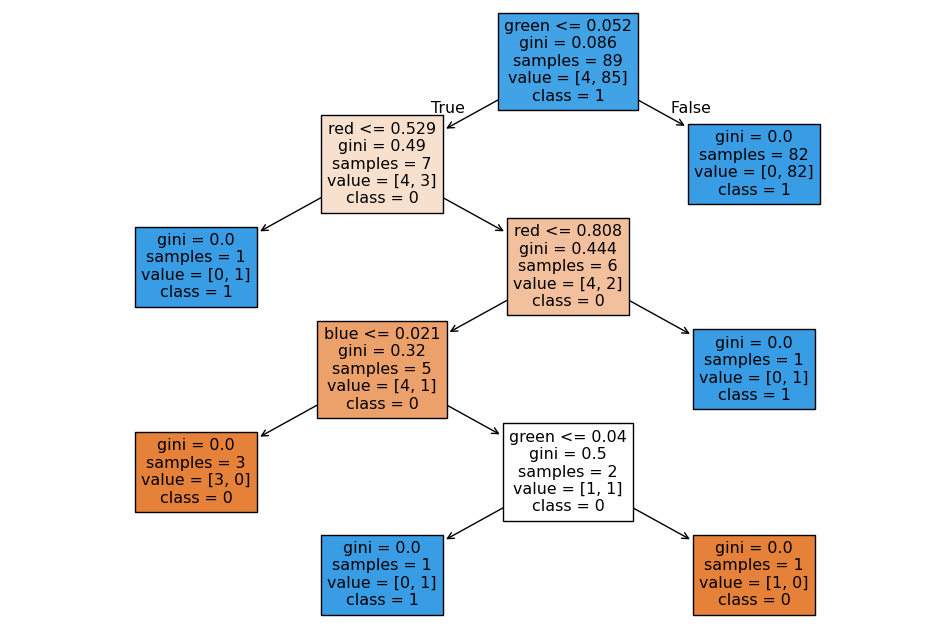

In [17]:
# Assuming merged_df is already loaded
# Separate features and target
X = goes_tsi_df[['red', 'green', 'blue']]  # Features
y = goes_tsi_df['cloud_binary']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['red', 'green', 'blue'], class_names=['0', '1'], filled=True)
plt.show()